# Deep Learning in Python Project: Gender Prediction by Name

### Lisette Sibbald 13280376, Felice Wulfse 13237071 & Sophie Elting 13316338

This notebook takes the reader through our project concerning the prediction of gender based on name. 
We will use an Long Short Term Memory Recurrent Neural Network (LSTM RNN) to learn gender from name. So a binary outcome from character input (based on the names). We have chosen for a LSTM RNN for this task, since names can be thought of as a sequence of characters (and sequences are suited fot a LSTM). Learning from patterns in these sequences could make it possible for a neural network to make predictions.

This notebook starts with the data import and inspection, followed by data preparation, followed by model building and training and finally model performance evaluation. 

First we will import relevant packages.

In [1]:
from __future__ import print_function

from sklearn.preprocessing import OneHotEncoder

from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

from matplotlib import pyplot as plt

from tensorflow.keras import callbacks

import numpy as np
import pandas as pd
import os
import re

print("import succesful")

Matplotlib is building the font cache; this may take a moment.


import succesful


## Data import and inspection

Next we will import the data set, It comes from https://archive.ics.uci.edu/ml/datasets/Gender+by+Name.
It's description states:

"This data set combines raw counts for first/given names of male and female babies in those time periods, and then calculates a probability for a name given the aggregate count. Source datasets are from government authorities: 
-US: Baby Names from Social Security Card Applications - National Data, 1880 to 2019 
-UK: Baby names in England and Wales Statistical bulletins, 2011 to 2018 
-Canada: British Columbia 100 Years of Popular Baby names, 1918 to 2018 
-Australia: Popular Baby Names, Attorney-General's Department, 1944 to 2019"

There are 147270 names in total. For this project we will be using the "Name" and "Gender" variable, so we will filter these two variables from the data set. 

In [2]:
complete = pd.read_csv('name_gender_dataset.csv')

complete.head() # inspect the complete data set

data = complete[["Name", "Gender"]]

data.head() # inspect the filtered dataset

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M


Next we will do more inspection on our data. We will be counting the number of males and females in the dataset. 
There are more females than males in our data set, but not problematically more. We think both genders have enough data to train and validate.

In [3]:
data.groupby('Gender')['Name'].count()

Gender
F    89749
M    57520
Name: Name, dtype: int64

## Data preparation and one-hot coding

No we will continue with data preparation. All 'weird' characters that might be included in the names are removed. We will only keep letters, capital letters, letters with accents/umlaut and the special character '-'. 

In [4]:
names = data['Name']
gender = data['Gender']

names_cleaned = []
for i in range(len(names)): # keep only the following characters in the names, delete all other characters
    names_cleaned.append(re.sub('[^a-zA-ZÀ-ÿ\-]', '', names[i]))

print(names_cleaned[0:20]) # inspect cleaned names

['James', 'John', 'Robert', 'Michael', 'William', 'Mary', 'David', 'Joseph', 'Richard', 'Charles', 'Thomas', 'Christopher', 'Daniel', 'Matthew', 'Elizabeth', 'Patricia', 'Jennifer', 'Anthony', 'George', 'Linda']


Next we need to be able to transform the names to model input. In our case, one-hot coding for the LSTM. For this we need the present characters in the data set. 
'END' is added to vocab, since we will be using 'END' later for solving input problems. More is explained later.
Code base retrieved from Deepak Babu (2016).

In [5]:
vocab = set(' '.join([str(i) for i in names_cleaned])) # get all individual, distinct characters
vocab.add('END') # add 'END' to vocab
len_vocab = len(vocab)

In [6]:
print(vocab)
print("vocab length is ",len_vocab)
print ("number of names ",len(data))

{'l', '-', 'C', 'o', 'z', 'g', 'P', 'w', 'J', 'G', 'Y', 'E', 'U', 'd', 'e', 'M', 'END', 'I', 'T', 'x', 'L', 'Z', 'N', 'k', ' ', 'à', 'h', 's', 'm', 'p', 'v', 'ö', 't', 'X', 'y', 'u', 'R', 'r', 'i', 'H', 'F', 'S', 'D', 'q', 'Q', 'K', 'a', 'W', 'B', 'n', 'O', 'c', 'f', 'V', 'j', 'A', 'b'}
vocab length is  57
number of names  147269


So there are 57 characters in our vocabulary and still 147269 names.

Next we will need to give every character a number as preparation for the one-hot coding. Code base retrieved from Deepak Babu (2016).

In [7]:
char_index = dict((c, i) for i, c in enumerate(vocab)) # create a dictionary with the elements of vocab and a number.

In [8]:
print(char_index) # inspect the index with their corresponding characters
len(char_index)

{'l': 0, '-': 1, 'C': 2, 'o': 3, 'z': 4, 'g': 5, 'P': 6, 'w': 7, 'J': 8, 'G': 9, 'Y': 10, 'E': 11, 'U': 12, 'd': 13, 'e': 14, 'M': 15, 'END': 16, 'I': 17, 'T': 18, 'x': 19, 'L': 20, 'Z': 21, 'N': 22, 'k': 23, ' ': 24, 'à': 25, 'h': 26, 's': 27, 'm': 28, 'p': 29, 'v': 30, 'ö': 31, 't': 32, 'X': 33, 'y': 34, 'u': 35, 'R': 36, 'r': 37, 'i': 38, 'H': 39, 'F': 40, 'S': 41, 'D': 42, 'q': 43, 'Q': 44, 'K': 45, 'a': 46, 'W': 47, 'B': 48, 'n': 49, 'O': 50, 'c': 51, 'f': 52, 'V': 53, 'j': 54, 'A': 55, 'b': 56}


57

Before the next step of creating input we will first create a test and train set. We will go for a 80% train set and 20% test split. Code base retrieved from Deepak Babu (2016).

In [9]:
#train test split
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

Next we will use the vocabulary library we created before to tranform every name to a set of numbers. All names that consist of less characters than the longest name will get filled up untill they reach the length of the longest name with the number that corresponds to 'END'. Code base retrieved from Deepak Babu (2016).

In [59]:
long_name = max(names, key = len)
maxlen = len(long_name)
print(maxlen)

train_X = []

trunc_train_name = [str(i)[0:maxlen] for i in train.Name]

# loop zorgt voor nummertjes voor elke naam (7 = END vult ie aan tot 30)
for i in trunc_train_name: # i = naam
    tmp = [char_index.get(j, []) for j in str(i)] # j = los character
    for k in range(0, maxlen - len(str(i))):
        tmp.append(char_index['END'])
    train_X.append(tmp)

train_X[0:2]

25


[[8,
  3,
  26,
  49,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16],
 [36,
  3,
  56,
  14,
  37,
  32,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16]]

In [11]:
np.asarray(train_X).shape # inspect the shape of the training set, as you can see, 25 is the length of the longest name

/Users/LisetteSibbald/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(117551, 25)

Here a function is defined to help with the one-hot coding. For that we want every number we now have assigned to get a 1 if its present, and a 0 when it's not present in a name.
The set_flag function will take a certain index and put a 1 in the place of that index and tranform the other values to 0. Code base retrieved from Deepak Babu (2016).

In [12]:
def set_flag(i):
    tmp = np.zeros(57);
    tmp[i] = 1
    return(tmp)

In [13]:
set_flag(3) # inspect function output

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

Now we will use the previously defined set_flag function to tranform the training data to one-hot coding, and male and female to 1 and 0 respectively. Code base retrieved from Deepak Babu (2016).

In [14]:
# take input upto max and truncate rest
# encode to vector space(one hot encoding)
# padd 'END' to shorter sequences
# also convert each index to one-hot encoding
train_X = []
train_Y = []

trunc_train_name = [str(i)[0:maxlen] for i in train.Name]

for i in trunc_train_name:
    tmp = [set_flag(char_index.get(j, [])) for j in str(i)]
    for k in range(0,maxlen - len(str(i))):
        tmp.append(set_flag(char_index["END"]))
    train_X.append(tmp)
    
for i in train.Gender:
    if i == 'M':
        train_Y.append([1,0])
    else:
        train_Y.append([0,1])
    

In [15]:
np.asarray(train_X).shape # inspect shape, dimensions are right
np.asarray(train_Y).shape # again inspect shape, dimensions are right

(117551, 25, 57)

We will do the same with our test set. Code base retrieved from Deepak Babu (2016).

In [61]:
test_X = []
test_Y = []
trunc_test_name = [str(i)[0:maxlen] for i in test.Name]
for i in trunc_test_name:
    tmp = [set_flag(char_index.get(j, [])) for j in str(i)]
    for k in range(0,maxlen - len(str(i))):
        tmp.append(set_flag(char_index["END"]))
    test_X.append(tmp)
for i in test.Gender:
    if i == 'M':
        test_Y.append([1,0])
    else:
        test_Y.append([0,1])

In [21]:
print(np.asarray(test_X).shape)
print(np.asarray(test_Y).shape)

(29718, 25, 57)
(29718, 2)


## Model building

Before building the model we will define an early stopping element. We will let our model run for a maximum of 50 epochs, but to prevent overfitting we will introduce early stopping that will stop when model performance is going down. To be more sure that we will not stop in a local minimum, we will keep a patience of 5 epochs. 

In [17]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

For model building, we started out with a 2 stacked LSTM model, with 512 nodes in each layer together with 2 dropout layers with 0.2 dropout (to help with prevent overfitting). With that, we used softmax activation (because of our categorical output), used categorical crossentropy as a loss function, and the adam optimizer.

We have tried to tune our first model by using different settings and specifications in the model. For this, we have used a subset of our total data (n = 20000), in order to speed up the model training and thus enable us to test more options.

First, we have tried using less nodes (114 and 221 nodes) to see if that would increase test accuracy and test loss. Less nodes in the first layer would decrease variance in our model. With this we tried to find the optimal balance between variance and bias, because with a lot of nodes there is a more variance and with less nodes more bias. Perhaps our model had too much variance and could benefit from adding more bias instead of variance.
It ended up that both did not improve our accuracy and therefore we kept the 512 nodes. 

Next to that we have have tried out adding another layer. It turned out that adding one layer with 512 nodes together with a dropout layer with 0.5 dropout improved the accuracy of our model. The higher dropout would help with overfitting, since the model is 'forced' to find more general, robust patterns. 

With this, we ended up with our final model below. A 3 layered LSTM RNN model with 512 nodes per layer, 2 dropout layers with 0.2 dropout and a last dropout layer with 0.5 dropout. We decided to keep using the softmax activation, the categorical crossentropy as a loss function and the adam optimizer. Code base retrieved from Deepak Babu (2016).

In [62]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen,len_vocab)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Model build')

Model build


## Model training
Code base retrieved from Deepak Babu (2016).

In [22]:
# transform to a Numpy array as a requirement for model.fit
train_X = np.asarray(train_X)
train_Y = np.asarray(train_Y)
test_X = np.asarray(test_X)
test_Y = np.asarray(test_Y)

In [23]:
batch_size=1000
history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=50, validation_data=(test_X, test_Y), callbacks=[early_stopping])

Epoch 1/50
118/118 [==============================] - 1483s 13s/step - loss: 0.5781 - accuracy: 0.6965 - val_loss: 0.5281 - val_accuracy: 0.7365
Epoch 2/50
118/118 [==============================] - 1407s 12s/step - loss: 0.5083 - accuracy: 0.7553 - val_loss: 0.4801 - val_accuracy: 0.7749
Epoch 3/50
118/118 [==============================] - 1410s 12s/step - loss: 0.4763 - accuracy: 0.7748 - val_loss: 0.4672 - val_accuracy: 0.7817
Epoch 4/50
118/118 [==============================] - 1401s 12s/step - loss: 0.4609 - accuracy: 0.7857 - val_loss: 0.4556 - val_accuracy: 0.7888
Epoch 5/50
118/118 [==============================] - 1408s 12s/step - loss: 0.4493 - accuracy: 0.7922 - val_loss: 0.4506 - val_accuracy: 0.7902
Epoch 6/50
118/118 [==============================] - 1455s 12s/step - loss: 0.4427 - accuracy: 0.7956 - val_loss: 0.4440 - val_accuracy: 0.7956
Epoch 7/50
118/118 [==============================] - 1409s 12s/step - loss: 0.4353 - accuracy: 0.7991 - val_loss: 0.4407 - val_ac

We will save our model in case we would like to load it or it's weight again. 

In [24]:
model.save('mod_callback_extra.h5')
model.save_weights('callback_extra_weights.h5')

## Model performance

Next we will evaluate model performance. We will mainly be looking at test accuracy and loss. 

In [53]:
loss, acc = model.evaluate(test_X, test_Y, verbose = 2)
print('The final model has a test accuracy of: {:5.2f}%'.format(100 * acc))

929/929 - 261s - loss: 0.4078 - accuracy: 0.8174 - 261s/epoch - 281ms/step
The final model has a test accuracy of: 81.74%


Finally we will have a look at the history of model accuracy and model loss per epoch using a plot. Accuracy or loss is on the y-axis and number of epochs on the x-axis. 

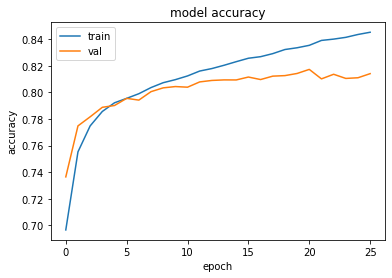

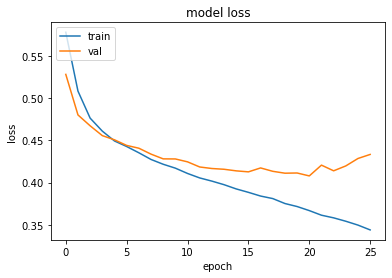

In [51]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As one can see in the accuracy plot, the validation accuracy stagnates after around 20-25 epochs. 
The loss plot shows almost the same pattern, however, there seems to be a slight increase of validation loss after 20-25 epochs. This might hint at a bit at overfitting.

## Additional performance measures

Next to model evaluation using a test set, we will use our model to predict gender from names we put in ourselves. Code base retrieved from Deepak Babu (2016).

In [56]:
name=["Sophie", "Felice", "Lisette", "Bart", "Raoul", "Hannes"]
X=[]

trunc_name = [i[0:maxlen] for i in name]
for i in trunc_name:
    tmp = [set_flag(char_index.get(j, [])) for j in str(i)]
    for k in range(0,maxlen - len(str(i))):
        tmp.append(set_flag(char_index["END"]))
    X.append(tmp)
    
pred=model.predict(np.asarray(X))

In [46]:
pred

array([[0.26723745, 0.7327626 ],
       [0.46749586, 0.53250414],
       [0.1011287 , 0.89887136],
       [0.75556576, 0.24443418],
       [0.5928819 , 0.4071181 ],
       [0.7933204 , 0.20667955]], dtype=float32)

We know that Sophie, Felice and Lisette are generally names given to females and Bart, Raoul and Hannes are generally names given to males. 

Here the model seems to do quite wel, predicting all genders correctly. However, it is more certain of some names than others. It has a bit more issues with 'Felice'. This could potentially be that the name Felice is present in the Dutch language and not in the languages used for model training. 

## Recommendations for future projects

We have a few recommendations and ideas for projects that could build on our project.

For example, our model selection phase is limited, mainly because of time and (computer) resources. Preferably we would like to have the time to use more cross-validation to assess the best model properties. Although an accuracy of 81% is already quite high. Also compared to a project that used a Naive Bayes Classifier for the purpose of predicting gender from name and got an accuracy of 73% (Huang, 2016).

Next one could study which names are mainly corrected wrong and see if maybe some of the names are underrepresented in the training set, they are unisex names or something else. Finding the reason behind misclassification could improve accuracy when improving the model.

Lastly one could add names from other languages as well to make the model more robust and general.

## References

Huang, R. (2016). Naive Bayes Name-Gender Classifier. Kaggle. URL: https://www.kaggle.com/springboardroger/naive-bayes-name-gender-classifier


Deepak Babu, P.R. (2016). Python/Deep learning gender/Deep Learning (RNN - LSTMs) Predict Gender from Name.ipynb. Github. URL: https://github.com/prdeepakbabu/Python/blob/master/Deep%20learning%20gender/Deep%20Learning%20(RNN%20-%20LSTMs)%20Predict%20Gender%20from%20Name.ipynb